# Confidence bounds changed, run evaluation again

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

import algorithms
import evaluation
from src import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
2,1,1,1,1,1
4,1,1,1,1,3
6,1,1,1,1,2
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12952,4,4,3,2,3
12953,4,4,3,2,1
12955,4,4,3,2,3
12956,4,4,3,2,1


In [6]:
all_rewards

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [7]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [8]:
all_rewards.shape[0]

10000

In [9]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [10]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [11]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]

In [12]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3396, 0.3366, 0.3238])

In [13]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [14]:
new_contexts.shape, new_rewards.shape

((10000, 5), (10000, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.022
Min expected reward for arm 3: 0.0


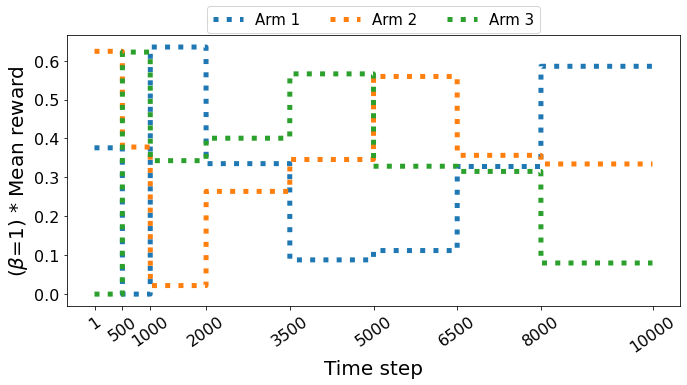

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


### Non-stationarity in costs

In [16]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [17]:
cost_means_range = [0.01, 0.07]

In [18]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [19]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [20]:
interval_means

[array([0.03247241, 0.06704286, 0.05391964, 0.04591951, 0.01936112]),
 array([0.01935967, 0.01348502, 0.06197057, 0.0460669 , 0.05248435]),
 array([0.01123507, 0.06819459, 0.05994656, 0.02274035, 0.0209095 ]),
 array([0.02100427, 0.02825453, 0.04148539, 0.0359167 , 0.02747375]),
 array([0.04671117, 0.01836963, 0.02752868, 0.03198171, 0.0373642 ])]

In [21]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [22]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

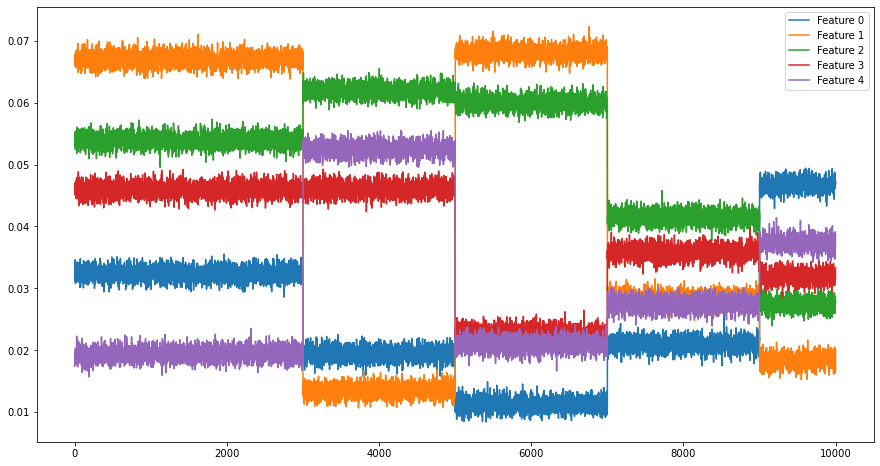

In [23]:
plot_costs(get_costs(), new_contexts.shape[0])

In [24]:
costs_obj = get_costs()

In [25]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [26]:
costs_vector.shape

(10000, 5)

## Save mean costs for plotting

In [27]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [28]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

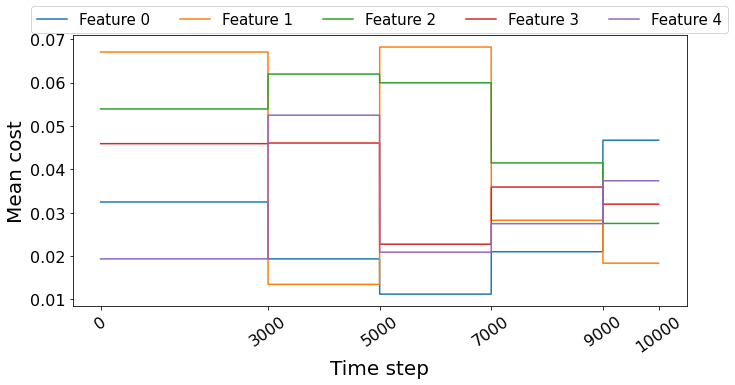

In [29]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for feature in range(new_contexts.shape[1]):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature}")

extraticks = full_cost_change_points
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"Mean cost", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

plt.show()

## Plot expected reward minus sum of costs

In [30]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.22633150496472904
Min expected gain for arm 2: -0.2036502630607873
Min expected gain for arm 3: -0.22429558772004018


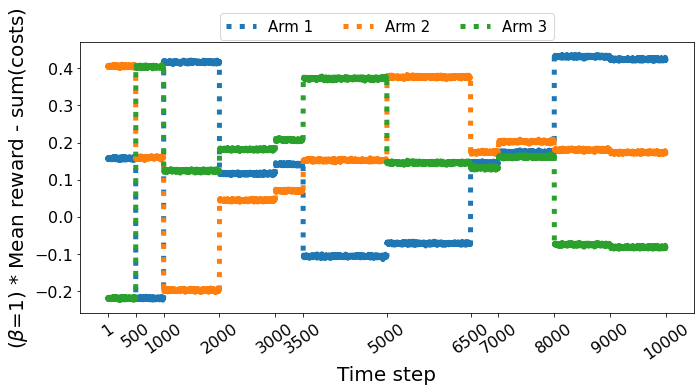

In [31]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


## Testing on non-stationary data

In [32]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 4

In [33]:
gains_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random, reward_random, cost_random, _ = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_random[i, :] = gain_random
    rewards_random[i, :] = reward_random
    costs_random[i, :] = cost_random
    
gain_random = np.mean(gains_random, axis=0)
reward_random = np.mean(rewards_random, axis=0)
cost_random = np.mean(costs_random, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 3334.0
	Total reward: 3334.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3413.0
	Total reward: 3413.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3250.0
	Total reward: 3250.0
	Total cost: 0
Execution time: 0.1s
Random policy
Beta = 1
Total gain: 3344.0
	Total reward: 3344.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3335.25


In [34]:
gains_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.03, n_arms=new_rewards.shape[1])

    gain_egreedy, reward_egreedy, cost_egreedy, _ = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_egreedy[i, :] = gain_egreedy
    rewards_egreedy[i, :] = reward_egreedy
    costs_egreedy[i, :] = cost_egreedy
    
gain_egreedy = np.mean(gains_egreedy, axis=0)
reward_egreedy = np.mean(rewards_egreedy, axis=0)
cost_egreedy = np.mean(costs_egreedy, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.03)
Beta = 1
Total gain: 4083.0
	Total reward: 4083.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 4044.0
	Total reward: 4044.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3497.0
	Total reward: 3497.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.03)
Beta = 1
Total gain: 3805.0
	Total reward: 3805.0
	Total cost: 0
Execution time: 0.1s
Average gain: 3857.25


In [35]:
gains_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.6,
        )

    gain_ucb, reward_ucb, cost_ucb, _ = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_ucb[i, :] = gain_ucb
    rewards_ucb[i, :] = reward_ucb
    costs_ucb[i, :] = cost_ucb

gain_ucb = np.mean(gains_ucb, axis=0)
reward_ucb = np.mean(rewards_ucb, axis=0)
cost_ucb = np.mean(costs_ucb, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.6)
Beta = 1
Total gain: 5177.0
	Total reward: 5177.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5177.0
	Total reward: 5177.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5177.0
	Total reward: 5177.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.6)
Beta = 1
Total gain: 5177.0
	Total reward: 5177.0
	Total cost: 0
Execution time: 0.1s
Average gain: 5177.0


In [36]:
gains_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb, reward_linucb, cost_linucb, _ = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_linucb[i, :] = gain_linucb
    rewards_linucb[i, :] = reward_linucb
    costs_linucb[i, :] = cost_linucb

gain_linucb = np.mean(gains_linucb, axis=0)
reward_linucb = np.mean(rewards_linucb, axis=0)
cost_linucb = np.mean(costs_linucb, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 3615.813345633983
	Total reward: 5495.0
	Total cost: 1879.1866543660212
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 3615.813345633983
	Total reward: 5495.0
	Total cost: 1879.1866543660212
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 3615.813345633983
	Total reward: 5495.0
	Total cost: 1879.1866543660212
Execution time: 0.3s
LinUCB (alpha=0.5)
Beta = 1
Total gain: 3615.813345633983
	Total reward: 5495.0
	Total cost: 1879.1866543660212
Execution time: 0.3s
Average gain: 3615.813345633983


In [37]:
gains_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.05,
    )


    gain_pslinucb, reward_pslinucb, cost_pslinucb, _  = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    change_points = ps_linucb.change_points
    gains_pslinucb[i, :] = gain_pslinucb
    rewards_pslinucb[i, :] = reward_pslinucb
    costs_pslinucb[i, :] = cost_pslinucb

gain_pslinucb = np.mean(gains_pslinucb, axis=0)
reward_pslinucb = np.mean(rewards_pslinucb, axis=0)
cost_pslinucb = np.mean(costs_pslinucb, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5471.8133456339865
	Total reward: 7351.0
	Total cost: 1879.1866543660212
Execution time: 0.4s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5471.8133456339865
	Total reward: 7351.0
	Total cost: 1879.1866543660212
Execution time: 0.4s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5471.8133456339865
	Total reward: 7351.0
	Total cost: 1879.1866543660212
Execution time: 0.5s
PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 5471.8133456339865
	Total reward: 7351.0
	Total cost: 1879.1866543660212
Execution time: 0.4s
Average gain: 5471.8133456339865


In [38]:
gains_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
simoos_objects = []


for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.8,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos, reward_simoos, cost_simoos, _ = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
    gains_simoos[i, :] = gain_simoos
    rewards_simoos[i, :] = reward_simoos
    costs_simoos[i, :] = cost_simoos
    simoos_objects.append(p_simoos)

gain_simoos = np.mean(gains_simoos, axis=0)
reward_simoos = np.mean(rewards_simoos, axis=0)
cost_simoos = np.mean(costs_simoos, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0022897720336914062 seconds
Trial 0, time 2022-06-09 13:54:21.007752
Trial 500, time 2022-06-09 13:54:33.905224
Trial 1000, time 2022-06-09 13:54:47.705737
Trial 1500, time 2022-06-09 13:54:48.010077
Trial 2000, time 2022-06-09 13:54:56.224680
Trial 2500, time 2022-06-09 13:55:09.246531
Trial 3000, time 2022-06-09 13:55:10.883690
Trial 3500, time 2022-06-09 13:55:41.838466
Trial 4000, time 2022-06-09 13:55:50.730899
Trial 4500, time 2022-06-09 13:55:52.330489
Trial 5000, time 2022-06-09 13:55:53.058418
Trial 5500, time 2022-06-09 13:55:53.201126
Trial 6000, time 2022-06-09 13:55:53.826302
Trial 6500, time 2022-06-09 13:55:54.994780
Trial 7000, time 2022-06-09 13:55:56.189807
Trial 7500, time 2022-06-09 13:55:57.386652
Trial 8000, time 2022-06-09 13:55:57.625086
Trial 8500, time 2022-06-09 13:55:57.769852
Trial 9000, time 2022-06-09 13:56:00.066413
Trial 9500, time 2022-06-09 13:56:02.701449
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 2887.2065000637444
	Total reward: 4009.0


In [39]:
gains_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
alg1_objects = []


for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta=BETA,
        delta=0.04,
        window_length=250,
        costs_range=COSTS_RANGE_SIZE,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1, reward_alg1, cost_alg1, _ = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1[i, :] = gain_alg1
        rewards_alg1[i, :] = reward_alg1
        costs_alg1[i, :] = cost_alg1
        
        alg1_objects.append(p_alg1)
        
gain_alg1 = np.mean(gains_alg1, axis=0)
reward_alg1 = np.mean(rewards_alg1, axis=0)
cost_alg1 = np.mean(costs_alg1, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0014541149139404297 seconds
Round 0, time 2022-06-09 14:05:29.563149
Round 500, time 2022-06-09 14:06:32.371800
Round 1000, time 2022-06-09 14:07:40.915983
Round 1500, time 2022-06-09 14:08:49.661562
Round 2000, time 2022-06-09 14:09:58.348140
Round 2500, time 2022-06-09 14:11:06.215542
Round 3000, time 2022-06-09 14:12:14.197437
Round 3500, time 2022-06-09 14:13:22.367198
Round 4000, time 2022-06-09 14:14:32.430802
Round 4500, time 2022-06-09 14:15:42.549778
Round 5000, time 2022-06-09 14:16:58.195927
Round 5500, time 2022-06-09 14:18:12.591684
Round 6000, time 2022-06-09 14:19:28.305073
Round 6500, time 2022-06-09 14:20:44.611131
Round 7000, time 2022-06-09 14:21:56.745998
Round 7500, time 2022-06-09 14:23:07.903432
Round 8000, time 2022-06-09 14:24:18.621415
Round 8500, time 2022-06-09 14:25:29.159873
Round 9000, time 2022-06-09 14:26:39.770158
Round 9500, time 2022-06-09 14:27:51.739661
Algorithm1 (beta=1, delta=0.04, w=250)
Beta = 1
Total gain: 6311.012558928556
	Total rewa

### Oracle

In [40]:
all_stationarity_regions = [(l, r) for l,r in zip(all_change_point_values, all_change_point_values[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)

In [41]:
gains_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1_oracle = algorithms.Algorithm1_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_means=cost_means,
        stationarity_periods=all_stationarity_regions,
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1_oracle, reward_alg1_oracle, cost_alg1_oracle, _ = evaluation.evaluate_on_synthetic_data(
            p_alg1_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1_oracle[i, :] = gain_alg1_oracle
        rewards_alg1_oracle[i, :] = reward_alg1_oracle
        costs_alg1_oracle[i, :] = cost_alg1_oracle


gain_alg1_oracle = np.mean(gains_alg1_oracle, axis=0)
reward_alg1_oracle = np.mean(rewards_alg1_oracle, axis=0)
cost_alg1_oracle = np.mean(costs_alg1_oracle, axis=0)
print(f"Average gain: {gain_alg1_oracle[-1]}")

Took 1.027266025543213 seconds
Trial 0, time 2022-06-09 16:09:42.181384
Trial 500, time 2022-06-09 16:09:42.193874
Trial 1000, time 2022-06-09 16:09:42.206127
Trial 1500, time 2022-06-09 16:09:42.223115
Trial 2000, time 2022-06-09 16:09:42.236205
Trial 2500, time 2022-06-09 16:09:42.243244
Trial 3000, time 2022-06-09 16:09:42.256196
Trial 3500, time 2022-06-09 16:09:42.274146
Trial 4000, time 2022-06-09 16:09:42.289974
Trial 4500, time 2022-06-09 16:09:42.305003
Trial 5000, time 2022-06-09 16:09:42.329482
Trial 5500, time 2022-06-09 16:09:42.346078
Trial 6000, time 2022-06-09 16:09:42.355877
Trial 6500, time 2022-06-09 16:09:42.373527
Trial 7000, time 2022-06-09 16:09:42.400306
Trial 7500, time 2022-06-09 16:09:42.418290
Trial 8000, time 2022-06-09 16:09:42.440450
Trial 8500, time 2022-06-09 16:09:42.460597
Trial 9000, time 2022-06-09 16:09:42.477001
Trial 9500, time 2022-06-09 16:09:42.490484
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 8719.532153825721
	Total reward: 9032.0
	Tota

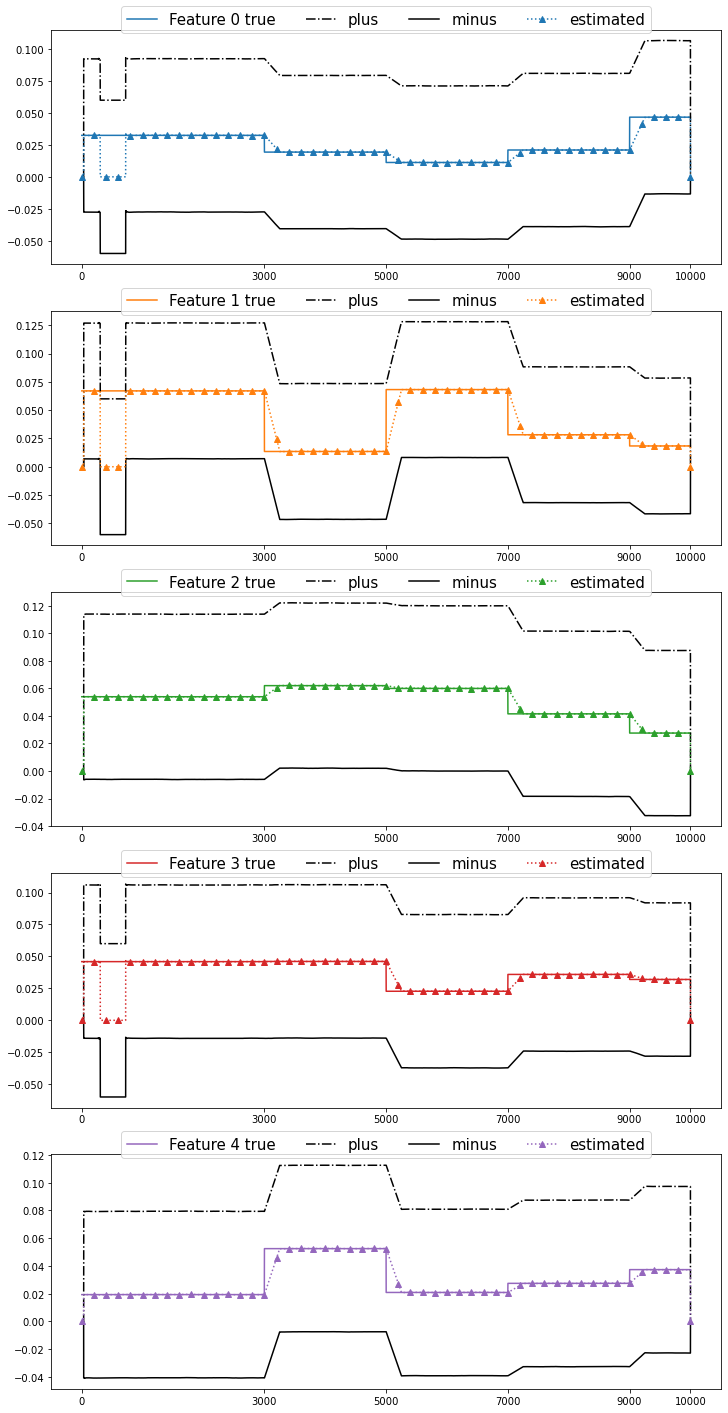

In [42]:
fig, axes = plt.subplots(new_contexts.shape[1], 1, figsize=(12, 5*new_contexts.shape[1]))

extraticks = full_cost_change_points

for feature, ax in enumerate(axes):
    ax.plot(mean_costs[:, feature], label=f"Feature {feature} true", color=plt.cm.tab10(feature))
    ax.plot(p_alg1.costs_plus_bound[:, feature] , linestyle='-.', color='k', label='plus')
    ax.plot(p_alg1.costs_minus_bound[:, feature] , color='k', label='minus')
    ax.plot(
        p_alg1.c_hats[:, feature], marker='^', markevery=200, linestyle=':',
        color=plt.cm.tab10(feature), label='estimated'
    )

    lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})

    ax.set_xticks(extraticks)
    
plt.show()

In [43]:
data_to_save = {
    'gain': {
        'Random': gain_random,
        r'$\epsilon$-greedy': gain_egreedy,
        'UCB1': gain_ucb,
        'LinUCB': gain_linucb,
        'PS-LinUCB': gain_pslinucb,
        'SimOOS': gain_simoos,
        'Algorithm1': gain_alg1,
        'Oracle': gain_alg1_oracle,
    },
    'reward': {
        'Random': reward_random,
        r'$\epsilon$-greedy': reward_egreedy,
        'UCB1': reward_ucb,
        'LinUCB': reward_linucb,
        'PS-LinUCB': reward_pslinucb,
        'SimOOS': reward_simoos,
        'Algorithm1': reward_alg1,
        'Oracle': reward_alg1_oracle,
    },
    'cost': {
        'Random': cost_random,
        r'$\epsilon$-greedy': cost_egreedy,
        'UCB1': cost_ucb,
        'LinUCB': cost_linucb,
        'PS-LinUCB': cost_pslinucb,
        'SimOOS': cost_simoos,
        'Algorithm1': cost_alg1,
        'Oracle': cost_alg1_oracle,
    },
    'gains': {
        'Random': gains_random,
        r'$\epsilon$-greedy': gains_egreedy,
        'UCB1': gains_ucb,
        'LinUCB': gains_linucb,
        'PS-LinUCB': gains_pslinucb,
        'SimOOS': gains_simoos,
        'Algorithm1': gains_alg1,
        'Oracle': gains_alg1_oracle,
    },
    'rewards': {
        'Random': rewards_random,
        r'$\epsilon$-greedy': rewards_egreedy,
        'UCB1': rewards_ucb,
        'LinUCB': rewards_linucb,
        'PS-LinUCB': rewards_pslinucb,
        'SimOOS': rewards_simoos,
        'Algorithm1': rewards_alg1,
        'Oracle': rewards_alg1_oracle,
    },
    'cosst': {
        'Random': costs_random,
        r'$\epsilon$-greedy': costs_egreedy,
        'UCB1': costs_ucb,
        'LinUCB': costs_linucb,
        'PS-LinUCB': costs_pslinucb,
        'SimOOS': costs_simoos,
        'Algorithm1': costs_alg1,
        'Oracle': costs_alg1_oracle,
    },
    'reward_change_points': change_point_values,
    'cost_change_points': cost_change_points,
    'all_change_points': all_change_point_values,
}

In [44]:
# with open('experiments/nursery/results/gains.pickle', 'wb') as f:
#     pickle.dump(data_to_save, f)

## Save algorithms too

In [45]:
algorithms_to_save = {
    'Random': p_random,
    r'$\epsilon$-greedy': egreedy,
    'UCB1': ucb_alg,
    'LinUCB': linucb,
    'PS-LinUCB': ps_linucb,
    'SimOOS': p_simoos,
    'Algorithm1': alg1_objects[0],
    'Oracle': p_alg1_oracle,
},

In [46]:
# with open('experiments/nursery/results/policy_objects.pickle', 'wb') as f:
#     pickle.dump(algorithms_to_save, f)

## Load data back

In [47]:
# with open('experiments/nursery/results/gains.pickle', 'rb') as f:
#     data_to_save = pickle.load(f)

In [48]:
gains = data_to_save['gain']

In [49]:
def plot_gains(gain_dict, reward_change_points=(), cost_change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    max_vline=0
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', 
                marker=mark, markevery=750, markersize=10,
                fillstyle='none', color=color,
                linewidth=3,
               )
        max_vline=max(max_vline, max(gain))
    
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4, label='Change Points'
    )
    
    
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=20)
    plt.yticks(fontsize=20)
    
    ax.set_xlabel('Time Step', fontsize=26)
    ax.set_ylabel('Cumulative Gain', fontsize=26)
    
    plt.legend(prop={'size': 20});
    plt.show();

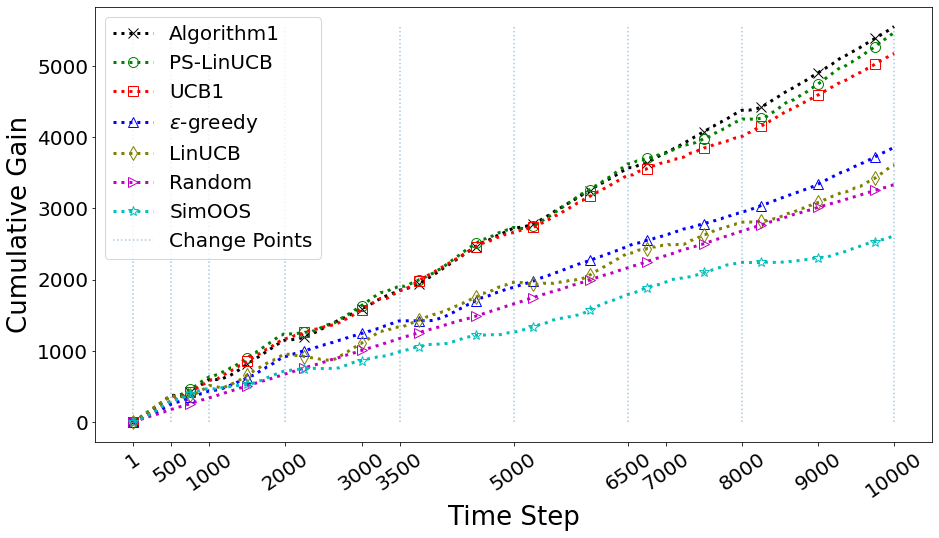

In [50]:
plot_gains(
    {
    'Random': gain_random,
    r'$\epsilon$-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
#     'Oracle': gain_alg1_oracle,
    },
    reward_change_points=change_point_values,
    cost_change_points=cost_change_points,
)


In [51]:
def plot_regrets(regret_dict, reward_change_points=(), cost_change_points=(), all_change_point_values=(),):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'blue'),
        1: ('>', 'g'),
        2: ('d','m'),
        3: ('<','goldenrod'),
        4: ('s','r'),
        5: ('o','dodgerblue'),
        6: ('^', 'k'),
    }
    
    sorted_regret_dict = {
        k:v for k,v in sorted(regret_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline=0
    for regret in sorted_regret_dict.values():
        max_vline=max(max_vline, max(regret))
        
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4, label='Change Points'
    )
        
    for ind, (label, regret) in enumerate(sorted_regret_dict.items()):
        
        if label == 'SimOOS':
            label_new = 'Sim-OOS'
        else:
            label_new = label
        
        mark, color = ind_to_params[ind]
        line, = ax.plot(regret, label=label_new, linestyle=':', 
                marker=mark, markevery=750, markersize=11, markeredgewidth=1.5,
                fillstyle='none', color=color,
                linewidth=3,
               )
        
        
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=25)
    plt.yticks(fontsize=25)
    
    ax.set_xlabel("Time Step", fontsize=38)
    ax.set_ylabel('Regret', fontsize=38)
    
    plt.legend(prop={'size': 22.5}, ncol=1);
    
#     plt.savefig('nursery_regret.pdf', bbox_inches='tight')
    
    plt.show();

In [52]:
regrets = {k: gain_alg1_oracle-v for k,v in gains.items() if k != 'Oracle'}

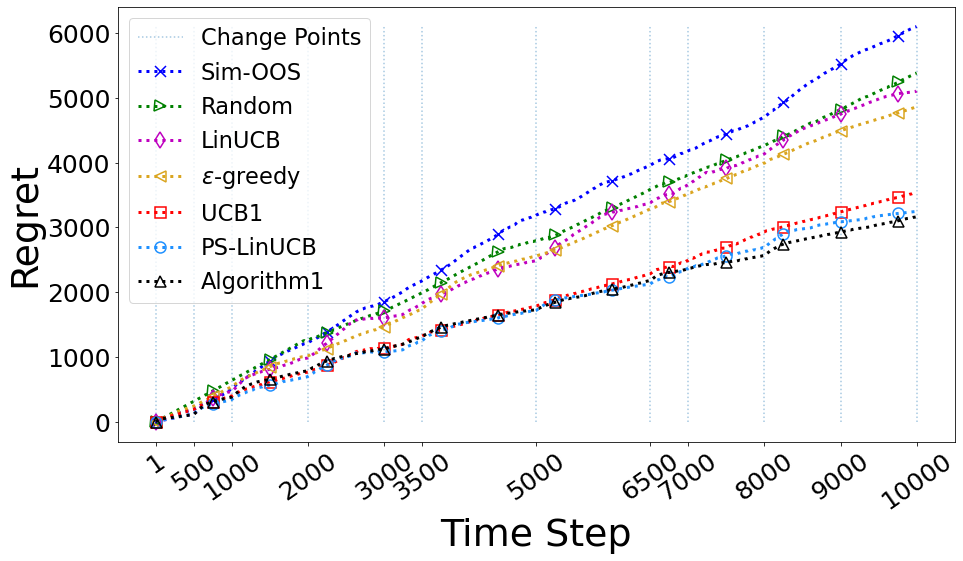

In [53]:
plot_regrets(
    regrets,
    reward_change_points=all_change_point_values,
    cost_change_points=all_change_point_values,
    all_change_point_values=all_change_point_values,
)
